# Cycle-Consistent Adversarial Networks

In the generative adversarial network (GAN) paradigm, one trains a generator network and a discriminator network jointly on the following objective

$$ \max_G \min_D \mathbb{E}_{x \sim p_{data}(x)}[\log(D(x))] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(x))] $$

The discriminator network is trying to perform binary classification between samples from the real data distribution and the ones from the generator, while the generator network is trying to fool the discriminator into thinking its samples are real. As both the discriminator and generator improve, the samples from the generator look more like samples from the real distribution.

We are interested in modifying this technique to perform image to image translation. This entails converting an image of one class to one of another, e.g. an image taken in the daytime to an image from the same location at nighttime. If one has pairs of such images, one can have the generator take in an image of one class and produce an image of the other class. We can also add a standard supervised learning objective in terms of an $\ell_1$ loss between the generated image and the ground truth. In the [pix2pix paper](https://arxiv.org/pdf/1611.07004.pdf), Isola et al. showed the success of this technique. They also noted that the noise vector is typically ignored by the generator, so they removed it. In this light, the discriminator acts as a feature discriminator instead of modeling a probability distribution.

However, we may not have pairs of images, but simply images from both classes. For this case, Zhu et al. proposed [Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf), or CycleGANs. They make a simple observation, the transformation from class X to class Y should be the inverse of the transformation from class Y to class X. They introduce a cycle-consistency $\ell_1$ loss to enforce this. Specifically, they train two generators, $G : X \to Y$ and $F: Y \to X$, and two discriminators, one for each direction. They train with a modified [least squares GAN loss](https://arxiv.org/pdf/1611.04076.pdf), as well as the cycle consistency loss

$$ \mathbb{E}_{x \sim p_{data}(x)} ||F(G(x)) - x||_1 + \mathbb{E}_{y \sim p_{data}(y)} ||G(F(y)) - y||_1 $$

They use the generator architecture from [Johnson et al.](https://arxiv.org/pdf/1603.08155.pdf) described in their [supplemental material](https://web.eecs.umich.edu/~justincj/papers/eccv16/JohnsonECCV16Supplementary.pdf), and the discriminator architecture from the pix2pix paper.

## Overview

We will first examine the apple2orange dataset from the CycleGAN paper. Then, we will implement the CycleGAN architecture and perform limited training on the apples2oranges dataset. Finally, we will examine generated images.

## A small experiment

First, we will download the dataset which consists of 995 images of apples and 1019 images of oranges. Downloading and unzipping will take approximately 157MB of disk space.

In [1]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
!unzip apple2orange.zip

--2021-03-28 14:27:59--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘apple2orange.zip’

apple2orange.zip    100%[===================>]  74.82M  2.50MB/s    in 33s     

2021-03-28 14:28:33 (2.24 MB/s) - ‘apple2orange.zip’ saved [78456409/78456409]

Archive:  apple2orange.zip
   creating: apple2orange/
   creating: apple2orange/trainA/
  inflating: apple2orange/trainA/n07740461_6908.jpg  
  inflating: apple2orange/trainA/n07740461_7635.jpg  
  inflating: apple2orange/trainA/n07740461_586.jpg  
  inflating: apple2orange/trainA/n07740461_9813.jpg  
  inflating: apple2orange/trainA/n07740461_6835.jpg  
  inflating: apple2orange/trainA/n07740461_2818.jpg  
  inflating: apple2ora

  inflating: apple2orange/trainA/n07740461_6216.jpg  
  inflating: apple2orange/trainA/n07740461_4399.jpg  
  inflating: apple2orange/trainA/n07740461_12372.jpg  
  inflating: apple2orange/trainA/n07740461_1629.jpg  
  inflating: apple2orange/trainA/n07740461_5856.jpg  
  inflating: apple2orange/trainA/n07740461_6695.jpg  
  inflating: apple2orange/trainA/n07740461_5962.jpg  
  inflating: apple2orange/trainA/n07740461_8068.jpg  
  inflating: apple2orange/trainA/n07740461_2583.jpg  
  inflating: apple2orange/trainA/n07740461_14593.jpg  
  inflating: apple2orange/trainA/n07740461_10166.jpg  
  inflating: apple2orange/trainA/n07740461_1778.jpg  
  inflating: apple2orange/trainA/n07740461_526.jpg  
  inflating: apple2orange/trainA/n07740461_2435.jpg  
  inflating: apple2orange/trainA/n07740461_2168.jpg  
  inflating: apple2orange/trainA/n07740461_12937.jpg  
  inflating: apple2orange/trainA/n07740461_1889.jpg  
  inflating: apple2orange/trainA/n07740461_14257.jpg  
  inflating: apple2orang

  inflating: apple2orange/trainA/n07740461_1698.jpg  
  inflating: apple2orange/trainA/n07740461_1677.jpg  
  inflating: apple2orange/trainA/n07740461_12713.jpg  
  inflating: apple2orange/trainA/n07740461_1859.jpg  
  inflating: apple2orange/trainA/n07740461_1993.jpg  
  inflating: apple2orange/trainA/n07740461_6616.jpg  
  inflating: apple2orange/trainA/n07740461_7094.jpg  
  inflating: apple2orange/trainA/n07740461_2278.jpg  
  inflating: apple2orange/trainA/n07740461_11613.jpg  
  inflating: apple2orange/trainA/n07740461_1985.jpg  
  inflating: apple2orange/trainA/n07740461_5122.jpg  
  inflating: apple2orange/trainA/n07740461_5135.jpg  
  inflating: apple2orange/trainA/n07740461_6394.jpg  
  inflating: apple2orange/trainA/n07740461_7887.jpg  
  inflating: apple2orange/trainA/n07740461_1283.jpg  
  inflating: apple2orange/trainA/n07740461_14825.jpg  
  inflating: apple2orange/trainA/n07740461_1754.jpg  
  inflating: apple2orange/trainA/n07740461_14273.jpg  
  inflating: apple2orang

  inflating: apple2orange/trainA/n07740461_13077.jpg  
  inflating: apple2orange/trainA/n07740461_8978.jpg  
  inflating: apple2orange/trainA/n07740461_3683.jpg  
  inflating: apple2orange/trainA/n07740461_1328.jpg  
  inflating: apple2orange/trainA/n07740461_8583.jpg  
  inflating: apple2orange/trainA/n07740461_1475.jpg  
  inflating: apple2orange/trainA/n07740461_4927.jpg  
  inflating: apple2orange/trainA/n07740461_10595.jpg  
  inflating: apple2orange/trainA/n07740461_15079.jpg  
  inflating: apple2orange/trainA/n07740461_2189.jpg  
  inflating: apple2orange/trainA/n07740461_9268.jpg  
  inflating: apple2orange/trainA/n07740461_13235.jpg  
  inflating: apple2orange/trainA/n07740461_1849.jpg  
  inflating: apple2orange/trainA/n07740461_496.jpg  
  inflating: apple2orange/trainA/n07740461_1336.jpg  
  inflating: apple2orange/trainA/n07740461_3998.jpg  
  inflating: apple2orange/trainA/n07740461_6729.jpg  
  inflating: apple2orange/trainA/n07740461_3143.jpg  
  inflating: apple2orange

  inflating: apple2orange/trainA/n07740461_11598.jpg  
  inflating: apple2orange/trainA/n07740461_1405.jpg  
  inflating: apple2orange/trainA/n07740461_8573.jpg  
  inflating: apple2orange/trainA/n07740461_11717.jpg  
  inflating: apple2orange/trainA/n07740461_2196.jpg  
  inflating: apple2orange/trainA/n07740461_5846.jpg  
  inflating: apple2orange/trainA/n07740461_6208.jpg  
  inflating: apple2orange/trainA/n07740461_409.jpg  
  inflating: apple2orange/trainA/n07740461_38.jpg  
  inflating: apple2orange/trainA/n07740461_8378.jpg  
  inflating: apple2orange/trainA/n07740461_6735.jpg  
  inflating: apple2orange/trainA/n07740461_12869.jpg  
  inflating: apple2orange/trainA/n07740461_1812.jpg  
  inflating: apple2orange/trainA/n07740461_13045.jpg  
  inflating: apple2orange/trainA/n07740461_8075.jpg  
  inflating: apple2orange/trainA/n07740461_4546.jpg  
  inflating: apple2orange/trainA/n07740461_5605.jpg  
  inflating: apple2orange/trainA/n07740461_8537.jpg  
  inflating: apple2orange/t

  inflating: apple2orange/testB/n07749192_7751.jpg  
  inflating: apple2orange/testB/n07749192_8211.jpg  
  inflating: apple2orange/testB/n07749192_5101.jpg  
  inflating: apple2orange/testB/n07749192_4681.jpg  
  inflating: apple2orange/testB/n07749192_1091.jpg  
  inflating: apple2orange/testB/n07749192_490.jpg  
  inflating: apple2orange/testB/n07749192_1571.jpg  
  inflating: apple2orange/testB/n07749192_4651.jpg  
  inflating: apple2orange/testB/n07749192_6710.jpg  
  inflating: apple2orange/testB/n07749192_7931.jpg  
  inflating: apple2orange/testB/n07749192_9311.jpg  
  inflating: apple2orange/testB/n07749192_9841.jpg  
  inflating: apple2orange/testB/n07749192_4751.jpg  
  inflating: apple2orange/testB/n07749192_5771.jpg  
  inflating: apple2orange/testB/n07749192_3651.jpg  
  inflating: apple2orange/testB/n07749192_6450.jpg  
  inflating: apple2orange/testB/n07749192_401.jpg  
  inflating: apple2orange/testB/n07749192_381.jpg  
  inflating: apple2orange/testB/n07749192_690.jpg

  inflating: apple2orange/trainB/n07749192_1116.jpg  
  inflating: apple2orange/trainB/n07749192_7658.jpg  
  inflating: apple2orange/trainB/n07749192_4448.jpg  
  inflating: apple2orange/trainB/n07749192_278.jpg  
  inflating: apple2orange/trainB/n07749192_6979.jpg  
  inflating: apple2orange/trainB/n07749192_3558.jpg  
  inflating: apple2orange/trainB/n07749192_5379.jpg  
  inflating: apple2orange/trainB/n07749192_4454.jpg  
  inflating: apple2orange/trainB/n07749192_7595.jpg  
  inflating: apple2orange/trainB/n07749192_639.jpg  
  inflating: apple2orange/trainB/n07749192_839.jpg  
  inflating: apple2orange/trainB/n07749192_3023.jpg  
  inflating: apple2orange/trainB/n07749192_4639.jpg  
  inflating: apple2orange/trainB/n07749192_11488.jpg  
  inflating: apple2orange/trainB/n07749192_4376.jpg  
  inflating: apple2orange/trainB/n07749192_418.jpg  
  inflating: apple2orange/trainB/n07749192_6796.jpg  
  inflating: apple2orange/trainB/n07749192_1009.jpg  
  inflating: apple2orange/train

  inflating: apple2orange/trainB/n07749192_9422.jpg  
  inflating: apple2orange/trainB/n07749192_553.jpg  
  inflating: apple2orange/trainB/n07749192_2239.jpg  
  inflating: apple2orange/trainB/n07749192_6747.jpg  
  inflating: apple2orange/trainB/n07749192_3209.jpg  
  inflating: apple2orange/trainB/n07749192_7435.jpg  
  inflating: apple2orange/trainB/n07749192_112.jpg  
  inflating: apple2orange/trainB/n07749192_10467.jpg  
  inflating: apple2orange/trainB/n07749192_1415.jpg  
  inflating: apple2orange/trainB/n07749192_2953.jpg  
  inflating: apple2orange/trainB/n07749192_7168.jpg  
  inflating: apple2orange/trainB/n07749192_3635.jpg  
  inflating: apple2orange/trainB/n07749192_1313.jpg  
  inflating: apple2orange/trainB/n07749192_1215.jpg  
  inflating: apple2orange/trainB/n07749192_7886.jpg  
  inflating: apple2orange/trainB/n07749192_1332.jpg  
  inflating: apple2orange/trainB/n07749192_4029.jpg  
  inflating: apple2orange/trainB/n07749192_6445.jpg  
  inflating: apple2orange/tra

  inflating: apple2orange/trainB/n07749192_4739.jpg  
  inflating: apple2orange/trainB/n07749192_209.jpg  
  inflating: apple2orange/trainB/n07749192_695.jpg  
  inflating: apple2orange/trainB/n07749192_332.jpg  
  inflating: apple2orange/trainB/n07749192_9845.jpg  
  inflating: apple2orange/trainB/n07749192_672.jpg  
  inflating: apple2orange/trainB/n07749192_3472.jpg  
  inflating: apple2orange/trainB/n07749192_6622.jpg  
  inflating: apple2orange/trainB/n07749192_8203.jpg  
  inflating: apple2orange/trainB/n07749192_12637.jpg  
  inflating: apple2orange/trainB/n07749192_1939.jpg  
  inflating: apple2orange/trainB/n07749192_2449.jpg  
  inflating: apple2orange/trainB/n07749192_5313.jpg  
  inflating: apple2orange/trainB/n07749192_4116.jpg  
  inflating: apple2orange/trainB/n07749192_5969.jpg  
  inflating: apple2orange/trainB/n07749192_7067.jpg  
  inflating: apple2orange/trainB/n07749192_7278.jpg  
  inflating: apple2orange/trainB/n07749192_2749.jpg  
  inflating: apple2orange/train

  inflating: apple2orange/trainB/n07749192_1434.jpg  
  inflating: apple2orange/trainB/n07749192_8052.jpg  
  inflating: apple2orange/trainB/n07749192_2247.jpg  
  inflating: apple2orange/trainB/n07749192_2562.jpg  
  inflating: apple2orange/trainB/n07749192_6873.jpg  
  inflating: apple2orange/trainB/n07749192_12484.jpg  
  inflating: apple2orange/trainB/n07749192_198.jpg  
  inflating: apple2orange/trainB/n07749192_3112.jpg  
  inflating: apple2orange/trainB/n07749192_11122.jpg  
  inflating: apple2orange/trainB/n07749192_12278.jpg  
  inflating: apple2orange/trainB/n07749192_8952.jpg  
  inflating: apple2orange/trainB/n07749192_292.jpg  
  inflating: apple2orange/trainB/n07749192_2787.jpg  
  inflating: apple2orange/trainB/n07749192_6374.jpg  
  inflating: apple2orange/trainB/n07749192_5003.jpg  
  inflating: apple2orange/trainB/n07749192_3962.jpg  
  inflating: apple2orange/trainB/n07749192_4033.jpg  
  inflating: apple2orange/trainB/n07749192_3387.jpg  
  inflating: apple2orange/t

  inflating: apple2orange/testA/n07740461_14600.jpg  
  inflating: apple2orange/testA/n07740461_9341.jpg  
  inflating: apple2orange/testA/n07740461_11651.jpg  
  inflating: apple2orange/testA/n07740461_12010.jpg  
  inflating: apple2orange/testA/n07740461_1250.jpg  
  inflating: apple2orange/testA/n07740461_780.jpg  
  inflating: apple2orange/testA/n07740461_2770.jpg  
  inflating: apple2orange/testA/n07740461_1191.jpg  
  inflating: apple2orange/testA/n07740461_7261.jpg  
  inflating: apple2orange/testA/n07740461_9070.jpg  
  inflating: apple2orange/testA/n07740461_40.jpg  
  inflating: apple2orange/testA/n07740461_6781.jpg  
  inflating: apple2orange/testA/n07740461_6901.jpg  
  inflating: apple2orange/testA/n07740461_2500.jpg  
  inflating: apple2orange/testA/n07740461_2840.jpg  
  inflating: apple2orange/testA/n07740461_5421.jpg  
  inflating: apple2orange/testA/n07740461_2151.jpg  
  inflating: apple2orange/testA/n07740461_13931.jpg  
  inflating: apple2orange/testA/n07740461_131

To avoid defining a custom dataset, we can simply add some dummy class folders to allow us to use the default "ImageFolder" dataset loader from torchvision.

In [2]:
!mkdir apple2orange/trainA/a/
!mkdir apple2orange/trainB/a/
!mkdir apple2orange/testA/a/
!mkdir apple2orange/testB/a/
!mv apple2orange/trainA/*.jpg apple2orange/trainA/a/
!mv apple2orange/trainB/*.jpg apple2orange/trainB/a/
!mv apple2orange/testA/*.jpg apple2orange/testA/a/
!mv apple2orange/testB/*.jpg apple2orange/testB/a/

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, CenterCrop, ToTensor

Now we will apply transformations to the dataset. We will resize the image so that its minimum side length is $64$ and do a center crop so it is $64 \times 64$. We will also recenter the image pixel values from $[0,1]$ to $[-1, 1]$, as our generator uses a "tanh".

In [4]:
class CenterAtZero(object):
    def __call__(self, image):
        return 2*image - 1

transform = torchvision.transforms.Compose([
    Resize(64),
    CenterCrop(64),
    ToTensor(),
    CenterAtZero()
])

datasetX = torchvision.datasets.ImageFolder('./apple2orange/trainA/', transform=transform)
datasetY = torchvision.datasets.ImageFolder('./apple2orange/trainB/', transform=transform)
datasetXtest = torchvision.datasets.ImageFolder('./apple2orange/testA/', transform=transform)
datasetYtest = torchvision.datasets.ImageFolder('./apple2orange/testB/', transform=transform)

batch_size = 1

# plt.imshow(datasetY[np.random.randint(len(datasetY))][0].permute(1,2,0))
dataloaderX = DataLoader(datasetX, batch_size=batch_size, shuffle=True, num_workers=2)
dataloaderY = DataLoader(datasetY, batch_size=batch_size, shuffle=True, num_workers=2)

Let's examine some images from the dataset.

There are 995 images of apples in the dataset.
There are 1019 images of oranges in the dataset.


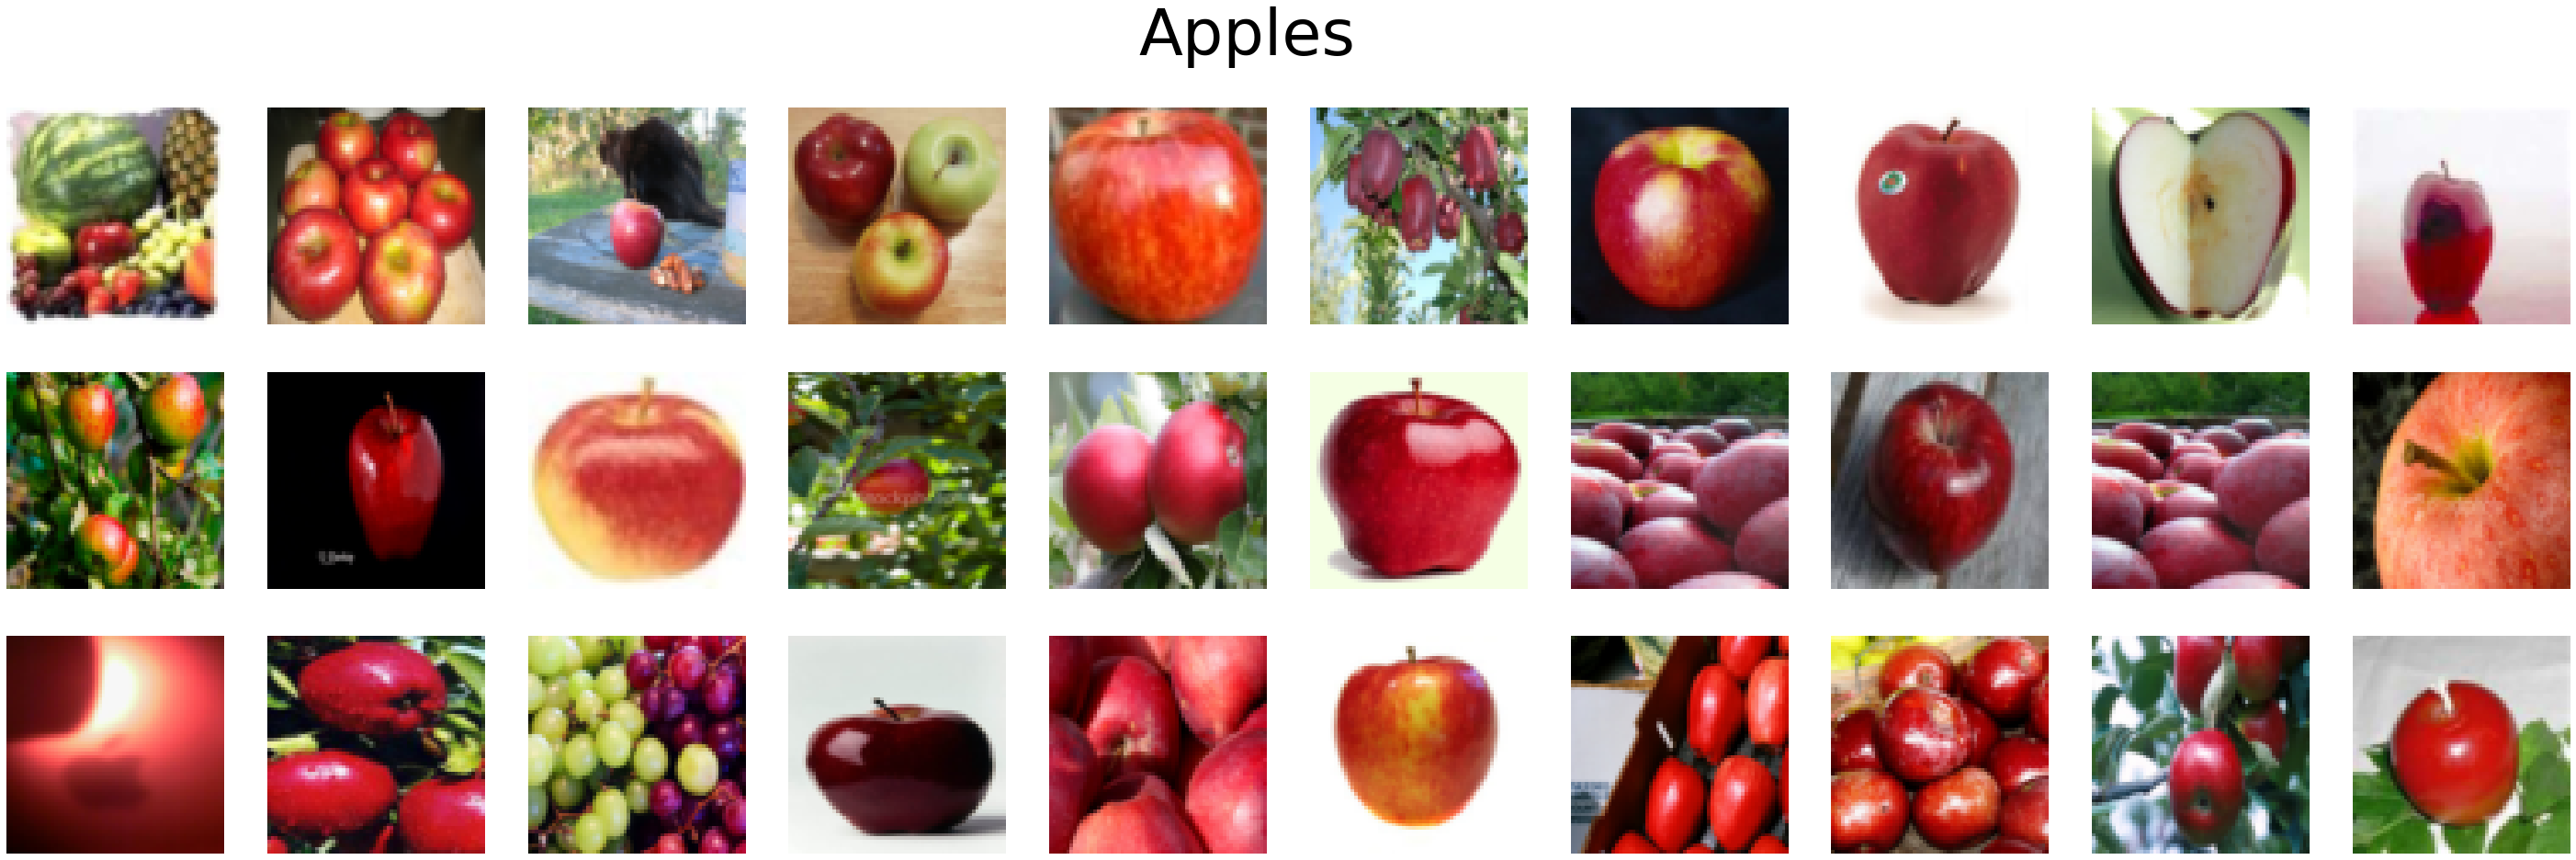

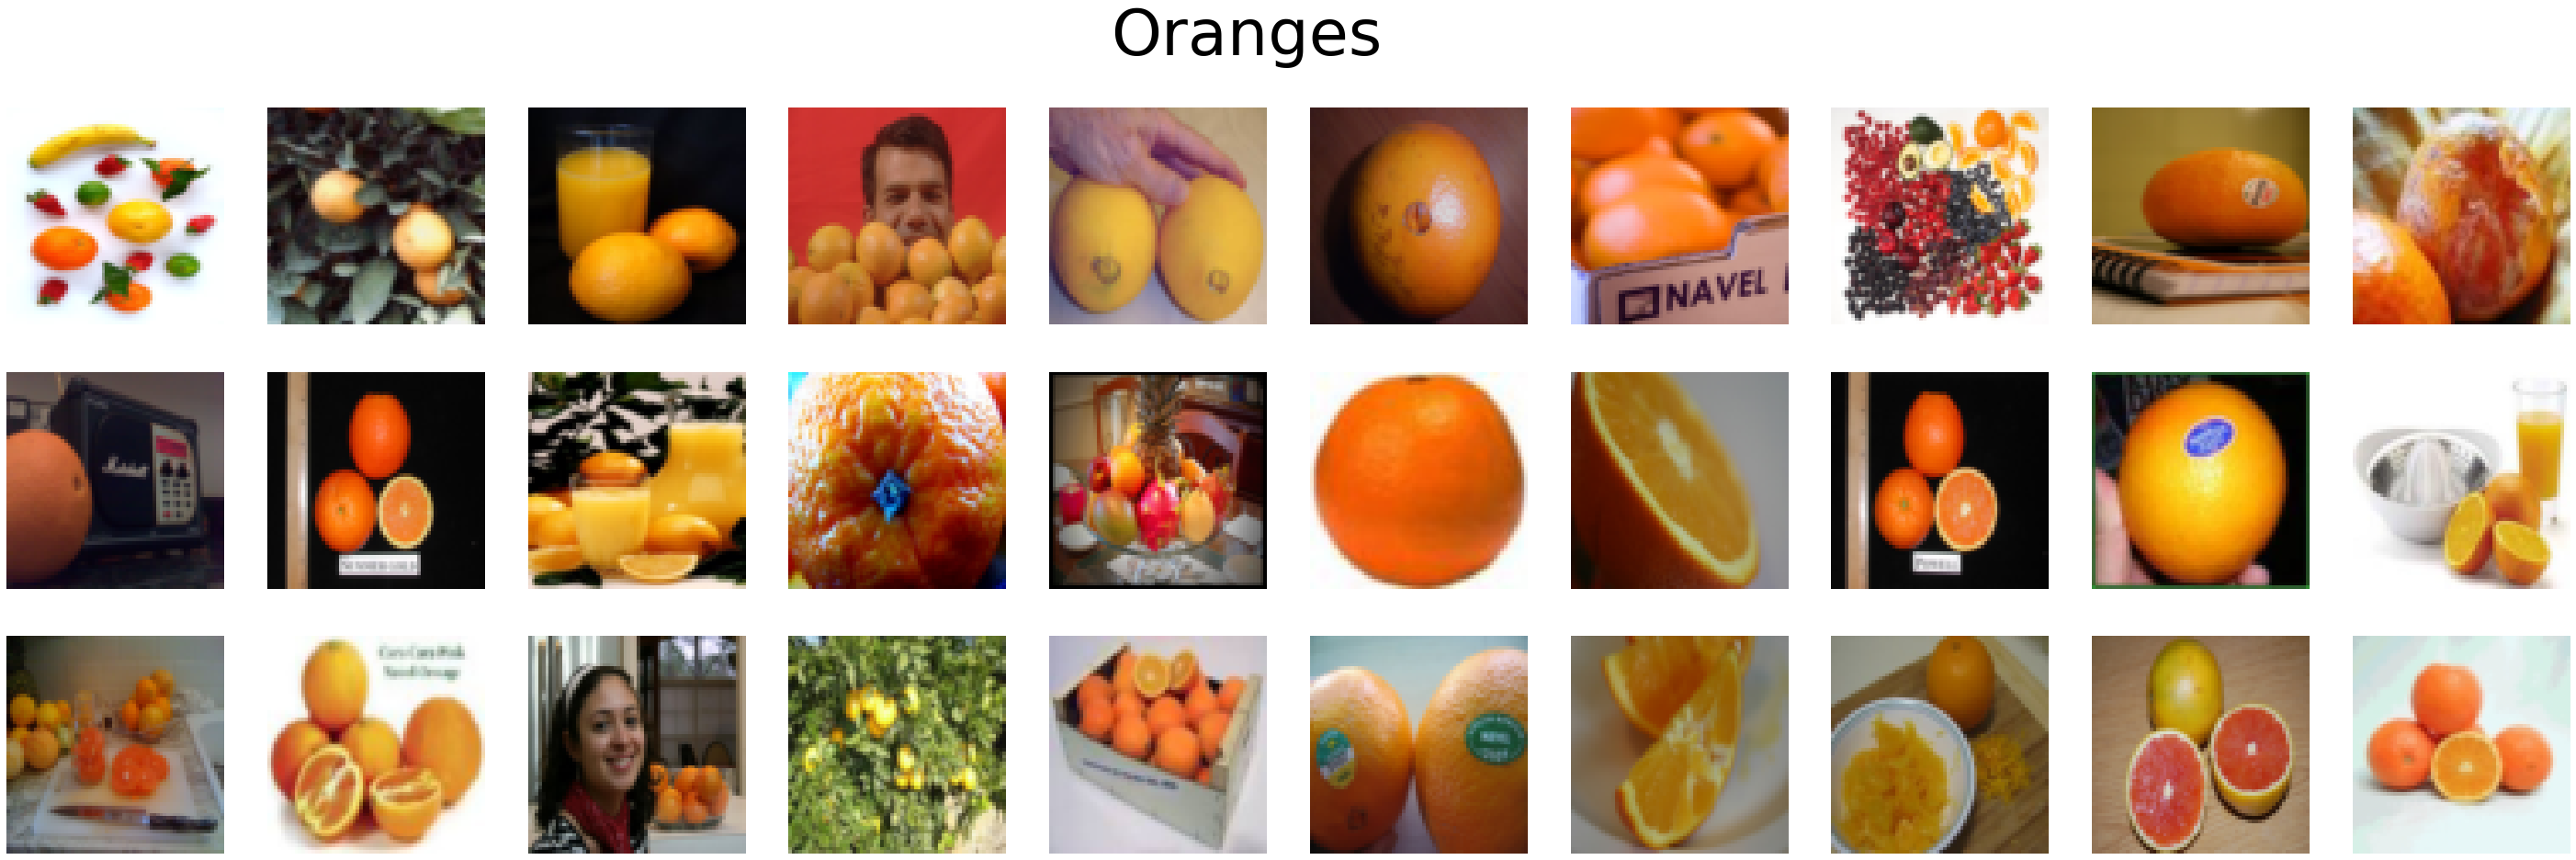

In [5]:
W = 10
H = 3
fig, axes = plt.subplots(H, W)
fig.suptitle('Apples', fontsize=70)
for row in axes:
    for ax in row:
        x = datasetX[np.random.randint(len(datasetX))][0]
        ax.imshow((x.permute(1,2,0).numpy()+1)/2)
        ax.axis('off')
fig.set_figheight(5*H)
fig.set_figwidth(5*W)

fig, axes = plt.subplots(H, W)
fig.suptitle('Oranges', fontsize=70)
for row in axes:
    for ax in row:
        y = datasetY[np.random.randint(len(datasetY))][0]
        ax.imshow((y.permute(1,2,0).numpy()+1)/2)
        ax.axis('off')
fig.set_figheight(5*H)
fig.set_figwidth(5*W)

print('There are ' + str(len(datasetX)) + ' images of apples in the dataset.')
print('There are ' + str(len(datasetY)) + ' images of oranges in the dataset.')

Now we will implement the generator and discriminator.

The original CycleGAN paper uses the architecture decribed in [Johnson et al.'s supplemental material](https://web.eecs.umich.edu/~justincj/papers/eccv16/JohnsonECCV16Supplementary.pdf) for the generator. This consists of strided convolutions to downsample, some residual convolution blocks, and fractionally strided convolutions to upscale. Unlike the supplemental material which does large padding before the first layer and no padding for the rest of the layers, the official [CycleGAN implementation](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) uses padding throughout all the layers. We will follow the CycleGAN version. We will be using a significantly smaller version of their model.

In [6]:
class ResBlock(nn.Module):
    def __init__(self, n_filters=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, (3,3), padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, (3,3), padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(n_filters)
        )
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m) == nn.Conv2d:
            m.weight.data.normal_(mean=0.0, std=0.02)
            if m.bias is not None:
                m.bias.data.zero_()
    
    def forward(self, x):
        return x + self.model(x)
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, (7,7), padding=3, padding_mode='reflect'),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3), padding=1, stride=2, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, (3,3), padding=1, stride=2, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            ResBlock(),
            ResBlock(),
            ResBlock(),
            ResBlock(),
            nn.ConvTranspose2d(64, 64, (3,3), padding=1, stride=2, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, (3,3), padding=1, stride=2, output_padding=1),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 3, (7,7), padding=3, padding_mode='reflect'),
            nn.Tanh()
        )
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m) == nn.ConvTranspose2d or \
           type(m) == nn.Conv2d:
            m.weight.data.normal_(mean=0.0, std=0.02)
            if m.bias is not None:
                m.bias.data.zero_()
            
    def forward(self, x):
        return self.model(x)

The CycleGAN paper uses the "PatchGAN" discriminator from the pix2pix paper. They simply do a limited number of convolutions, which results in a limited receptive field (a patch), and average the predictions for each patch.

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, (4,4), stride=2),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(32, 64, (4,4), stride=2),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(64, 128, (4,4), stride=2),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(128, 1, (4,4), stride=1)
        )
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m) == nn.Conv2d:
            m.weight.data.normal_(mean=0.0, std=0.02)
            if m.bias is not None:
                m.bias.data.zero_()
            
    def forward(self, x):
        x = self.model(x)
        x = x.mean((1,2,3))
        return x

Let's train! The CycleGAN paper uses a batch size of 1 and keeps a buffer of the last 50 generated images for the discriminator's objective, for stability.

The generator has 415683 parameters.
The discriminator has 167649 parameters.
Iteration 500 : Cycle_Loss 4.758503 : Dx_Loss 0.3449798 : Dy_Loss 0.115587
Iteration 1000 : Cycle_Loss 5.3874483 : Dx_Loss 0.13130108 : Dy_Loss 0.038851645
Iteration 1500 : Cycle_Loss 3.8188863 : Dx_Loss 0.05939319 : Dy_Loss 0.26756856
Iteration 2000 : Cycle_Loss 4.655102 : Dx_Loss 0.07292771 : Dy_Loss 0.055829838
Iteration 2500 : Cycle_Loss 2.182839 : Dx_Loss 0.19780724 : Dy_Loss 0.123804316
Iteration 3000 : Cycle_Loss 2.2342072 : Dx_Loss 0.23321368 : Dy_Loss 0.020417362
Iteration 3500 : Cycle_Loss 4.3309445 : Dx_Loss 0.05117072 : Dy_Loss 0.07187184
Iteration 4000 : Cycle_Loss 3.588696 : Dx_Loss 0.082935244 : Dy_Loss 0.17834581
Iteration 4500 : Cycle_Loss 4.1147747 : Dx_Loss 0.040909354 : Dy_Loss 0.03964474
Iteration 5000 : Cycle_Loss 3.422183 : Dx_Loss 0.041001704 : Dy_Loss 0.056424763
Iteration 5500 : Cycle_Loss 3.319079 : Dx_Loss 0.03506807 : Dy_Loss 0.019263048
Iteration 6000 : Cycle_Loss 4.5173764 : Dx_

Iteration 50000 : Cycle_Loss 1.4109285 : Dx_Loss 0.014176216 : Dy_Loss 0.0022745207
Iteration 50500 : Cycle_Loss 2.8501797 : Dx_Loss 0.022022994 : Dy_Loss 0.046420116
Iteration 51000 : Cycle_Loss 2.0747488 : Dx_Loss 0.023885727 : Dy_Loss 0.009835892
Iteration 51500 : Cycle_Loss 2.4040473 : Dx_Loss 0.022067891 : Dy_Loss 0.04023602
Iteration 52000 : Cycle_Loss 1.787166 : Dx_Loss 0.015814155 : Dy_Loss 0.031059878
Iteration 52500 : Cycle_Loss 2.1253893 : Dx_Loss 0.007831107 : Dy_Loss 0.019161426
Iteration 53000 : Cycle_Loss 1.8559623 : Dx_Loss 0.0263905 : Dy_Loss 0.024295136
Iteration 53500 : Cycle_Loss 2.564818 : Dx_Loss 0.013977911 : Dy_Loss 0.014229419
Iteration 54000 : Cycle_Loss 1.5876645 : Dx_Loss 0.0044452534 : Dy_Loss 0.003908716
Iteration 54500 : Cycle_Loss 2.7106948 : Dx_Loss 0.008387317 : Dy_Loss 0.0057903044
Iteration 55000 : Cycle_Loss 1.6510768 : Dx_Loss 0.014649205 : Dy_Loss 0.0064555495
Iteration 55500 : Cycle_Loss 2.0779295 : Dx_Loss 0.043700583 : Dy_Loss 0.007507643
Itera

CPU times: user 1h 22min 7s, sys: 8min 11s, total: 1h 30min 19s
Wall time: 1h 31min 5s


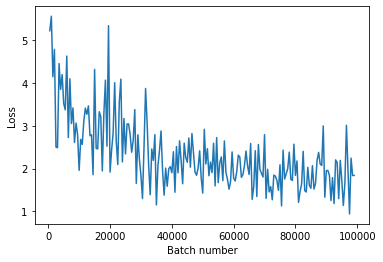

In [24]:
%%time

lam = 10 # Ratio of cycle loss vs GAN loss in objective
Gx = Generator() # Y -> X
Gy = Generator() # X -> Y
Dx = Discriminator() # Discriminates between real and fake X
Dy = Discriminator() # Discriminates between real and fake Y

### Taken from the PyTorch forums
num_params_g = sum(p.numel() for p in Gx.parameters() if p.requires_grad)
num_params_d = sum(p.numel() for p in Dx.parameters() if p.requires_grad)
###
print('The generator has ' + str(num_params_g) +
      ' parameters.')
print('The discriminator has ' + str(num_params_d) + ' parameters.')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Gx.to(device)
Gy.to(device)
Dx.to(device)
Dy.to(device)

Gx_optim = torch.optim.Adam(Gx.parameters(), lr=0.0002, betas=(0.5, 0.999))
Gy_optim = torch.optim.Adam(Gy.parameters(), lr=0.0002, betas=(0.5, 0.999))
Dx_optim = torch.optim.Adam(Dx.parameters(), lr=0.0002, betas=(0.5, 0.999))
Dy_optim = torch.optim.Adam(Dy.parameters(), lr=0.0002, betas=(0.5, 0.999))
MSELoss = torch.nn.MSELoss()
L1Loss = torch.nn.L1Loss()
n_epochs = 100
losses = []
iterations = []
batch_num = 0

buffer_size = 50
assert buffer_size % batch_size == 0
Gx_buffer = torch.zeros(buffer_size, 3, 64, 64, device=device)
Gy_buffer = torch.zeros(buffer_size, 3, 64, 64, device=device)
buf_ind = 0
buffer_full = False

r_label = torch.ones(1, device=device)
f_label = torch.zeros(1, device=device)

train = True # Whether or not we should train the network, or just load it

# Train the network
if train:
    for epoch in range(1,n_epochs+1):
        dataX = iter(dataloaderX)
        dataY = iter(dataloaderY)
        for i_batch in range(min(len(dataloaderX), len(dataloaderY))):   
            # Sample
            X, _ = next(dataX)
            Y, _ = next(dataY)
            X = X.to(device)
            Y = Y.to(device)

            # Add to buffer
            if not buffer_full:
                with torch.no_grad():
                    Gx_buffer[buf_ind:buf_ind+batch_size] = Gx(Y)
                    Gy_buffer[buf_ind:buf_ind+batch_size] = Gy(X)
                    buf_ind = buf_ind+batch_size 
                    if buf_ind >= buffer_size:
                        buf_ind = 0
                        buffer_full = True
                        
            else: # Don't start training until the buffer is full
                # Update Gx and Gy
                Gx_optim.zero_grad()
                Gy_optim.zero_grad()
                GxY = Gx(Y)
                GyX = Gy(X)
                cycle_loss = lam*(L1Loss(Gy(GxY), Y) + L1Loss(Gx(GyX), X))
                Gx_loss = MSELoss(Dx(GxY), r_label)
                Gy_loss = MSELoss(Dy(GyX), r_label)
                G_loss = lam*cycle_loss + Gx_loss + Gy_loss
                G_loss.backward()
                Gx_optim.step()
                Gy_optim.step()
                
                # Add to buffer
                Gx_buffer[buf_ind:buf_ind+batch_size] = GxY.detach()
                Gy_buffer[buf_ind:buf_ind+batch_size] = GyX.detach()
                buf_ind = buf_ind+batch_size 
                if buf_ind >= buffer_size:
                    buf_ind = 0
                    buffer_full = True
                
                
                # Update Dx
                Dx_loss = (MSELoss(Dx(X), r_label) + MSELoss(Dx(Gx_buffer), f_label))/2
                Dx_optim.zero_grad()
                Dx_loss.backward()
                Dx_optim.step()

                # Update Dy
                Dy_loss = (MSELoss(Dy(Y), r_label) + MSELoss(Dy(Gy_buffer), f_label))/2
                Dy_optim.zero_grad()
                Dy_loss.backward()
                Dy_optim.step()

            # Log
            if buffer_full and batch_num % 500 == 0:
                with torch.no_grad():
                    loss = (Dx_loss + Dy_loss + cycle_loss).cpu().numpy()
                    losses.append(loss)
                    iterations.append(batch_num)
                    print('Iteration ' + str(batch_num) + ' : Cycle_Loss ' + str(cycle_loss.cpu().numpy()) + \
                          ' : Dx_Loss ' + str(Dx_loss.cpu().numpy()) + ' : Dy_Loss ' + str(Dy_loss.cpu().numpy()))
            batch_num += 1
            
    torch.save(Gx.state_dict(), 'Gx.pt')
    torch.save(Gy.state_dict(), 'Gy.pt')
    torch.save(Dx.state_dict(), 'Dx.pt')
    torch.save(Dy.state_dict(), 'Dy.pt')

    plt.plot(iterations, losses)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    
# Load the network
else:
    Gx.load_state_dict(torch.load('Gx.pt'))
    Gy.load_state_dict(torch.load('Gy.pt'))
    Dx.load_state_dict(torch.load('Dx.pt'))
    Dy.load_state_dict(torch.load('Dy.pt'))

Now let's examine some translations from images in the test set. The original image will be above its translation.

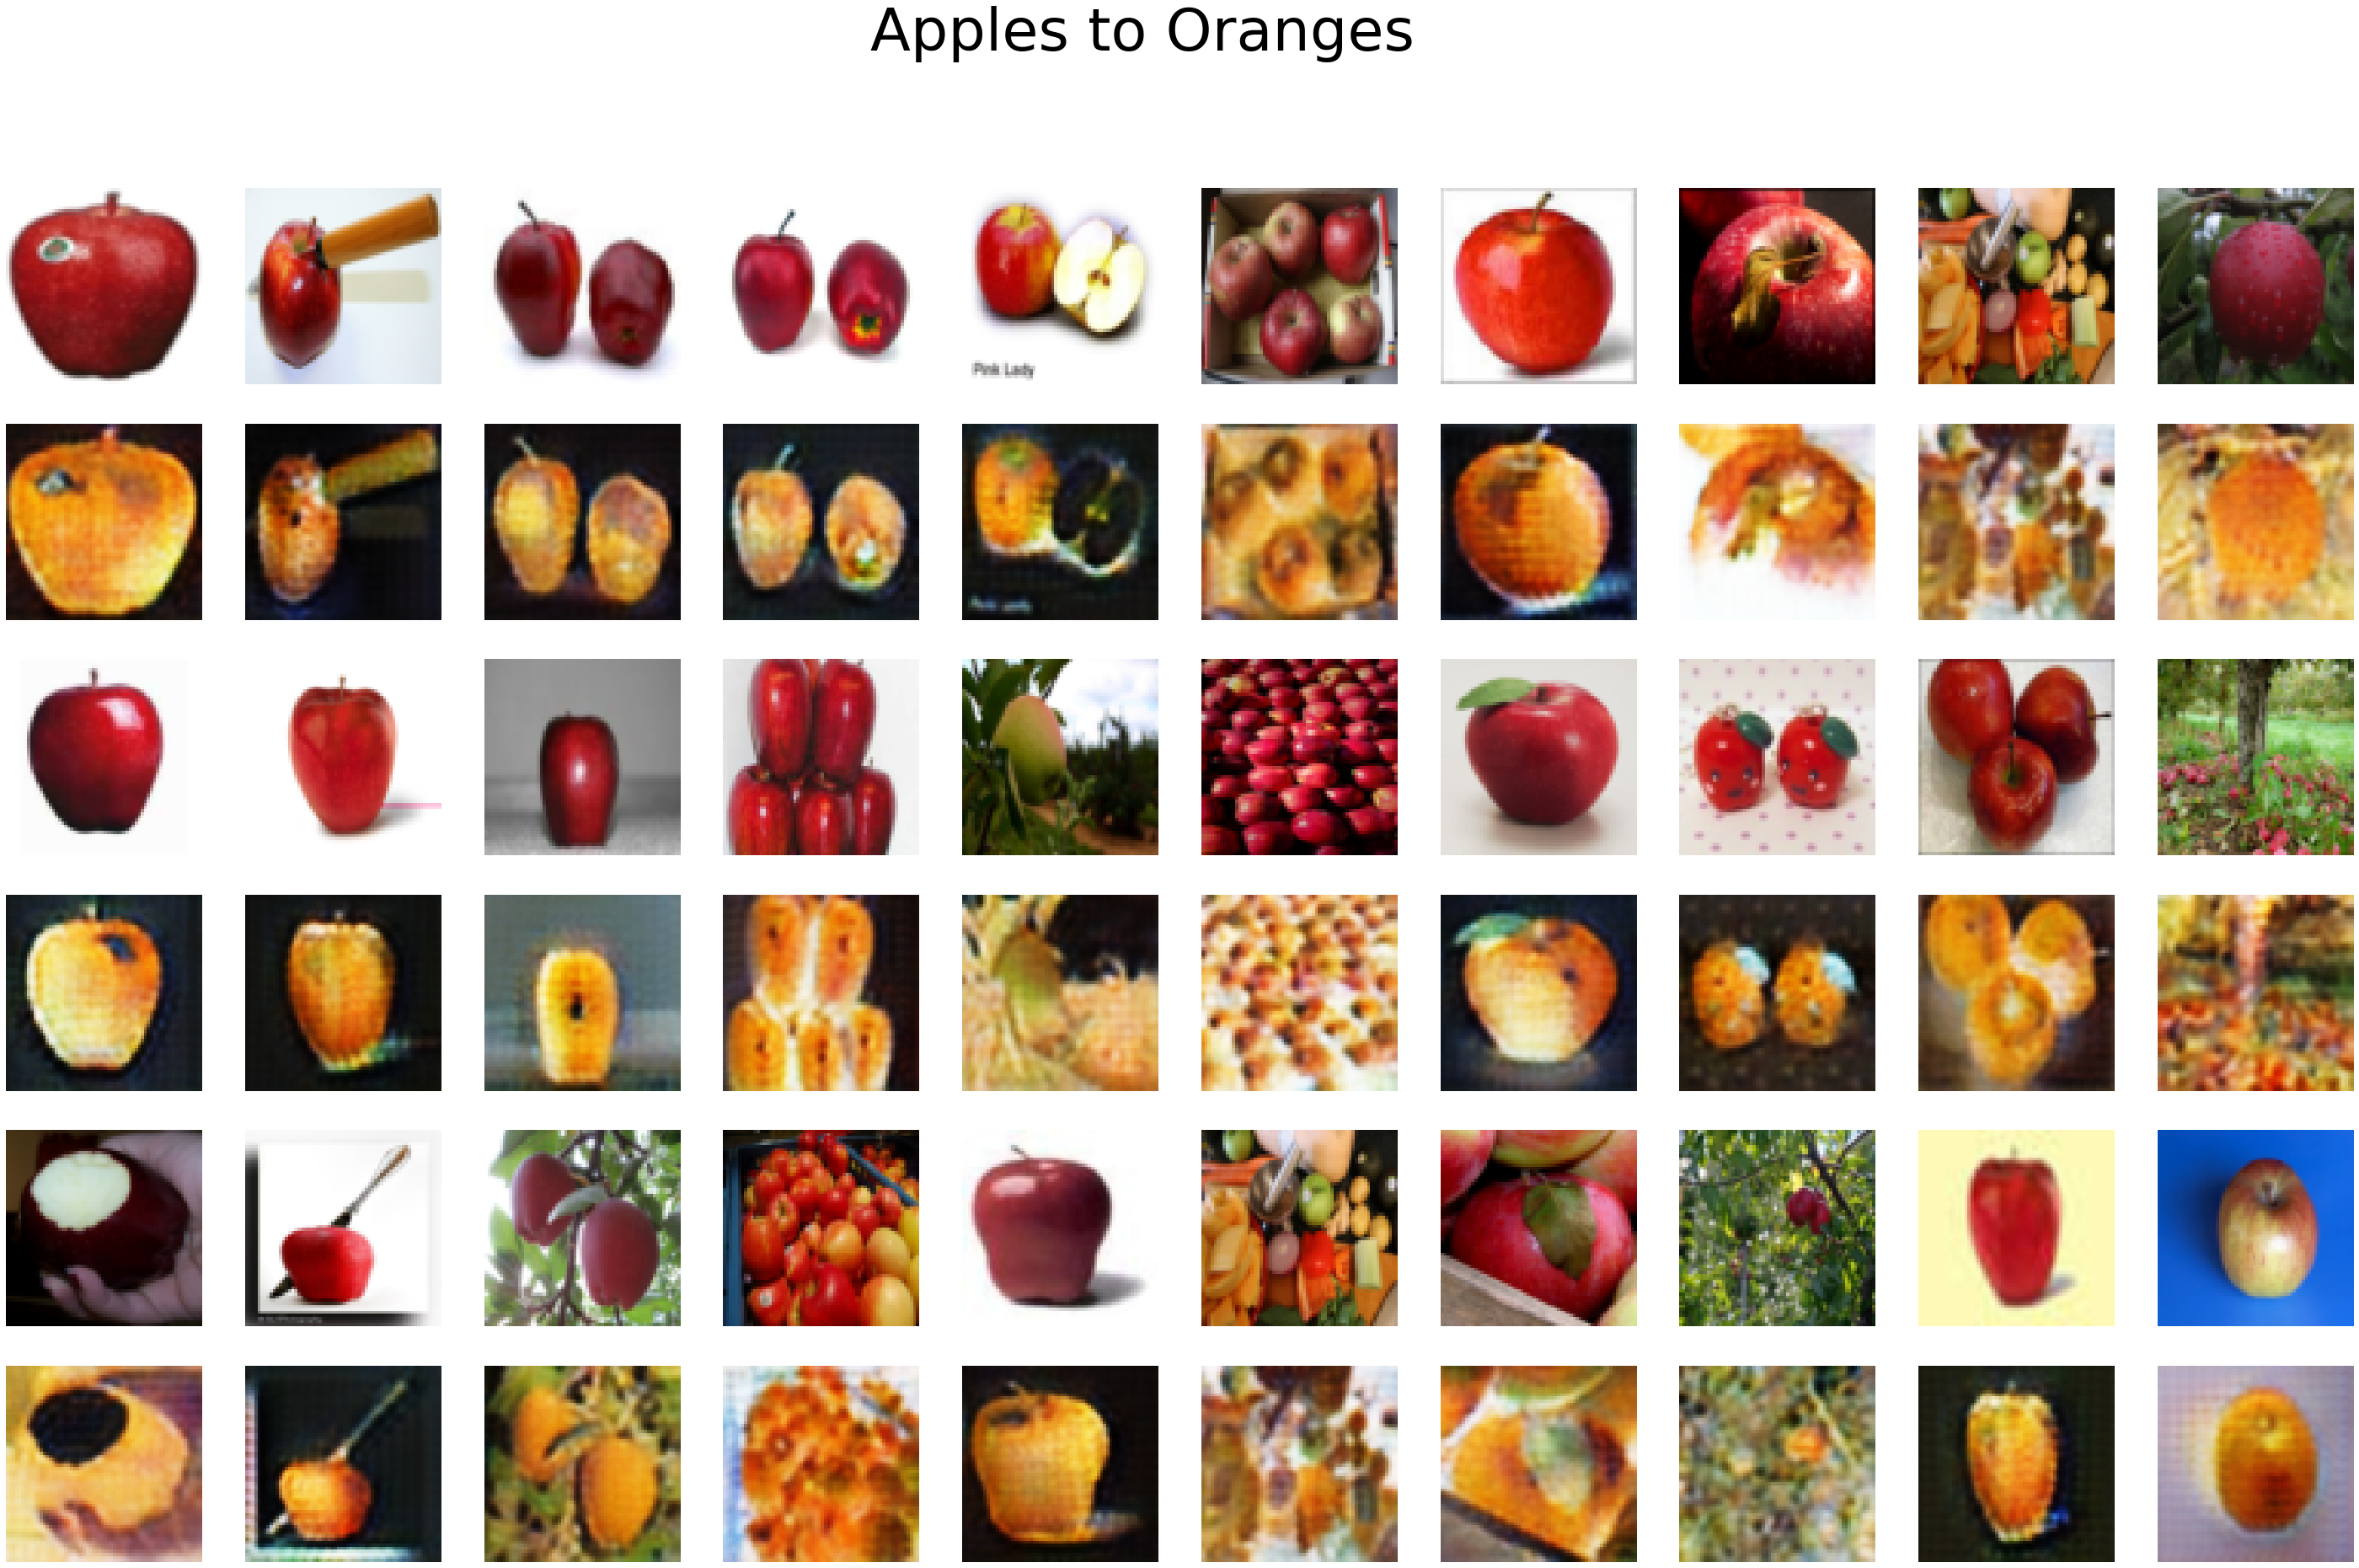

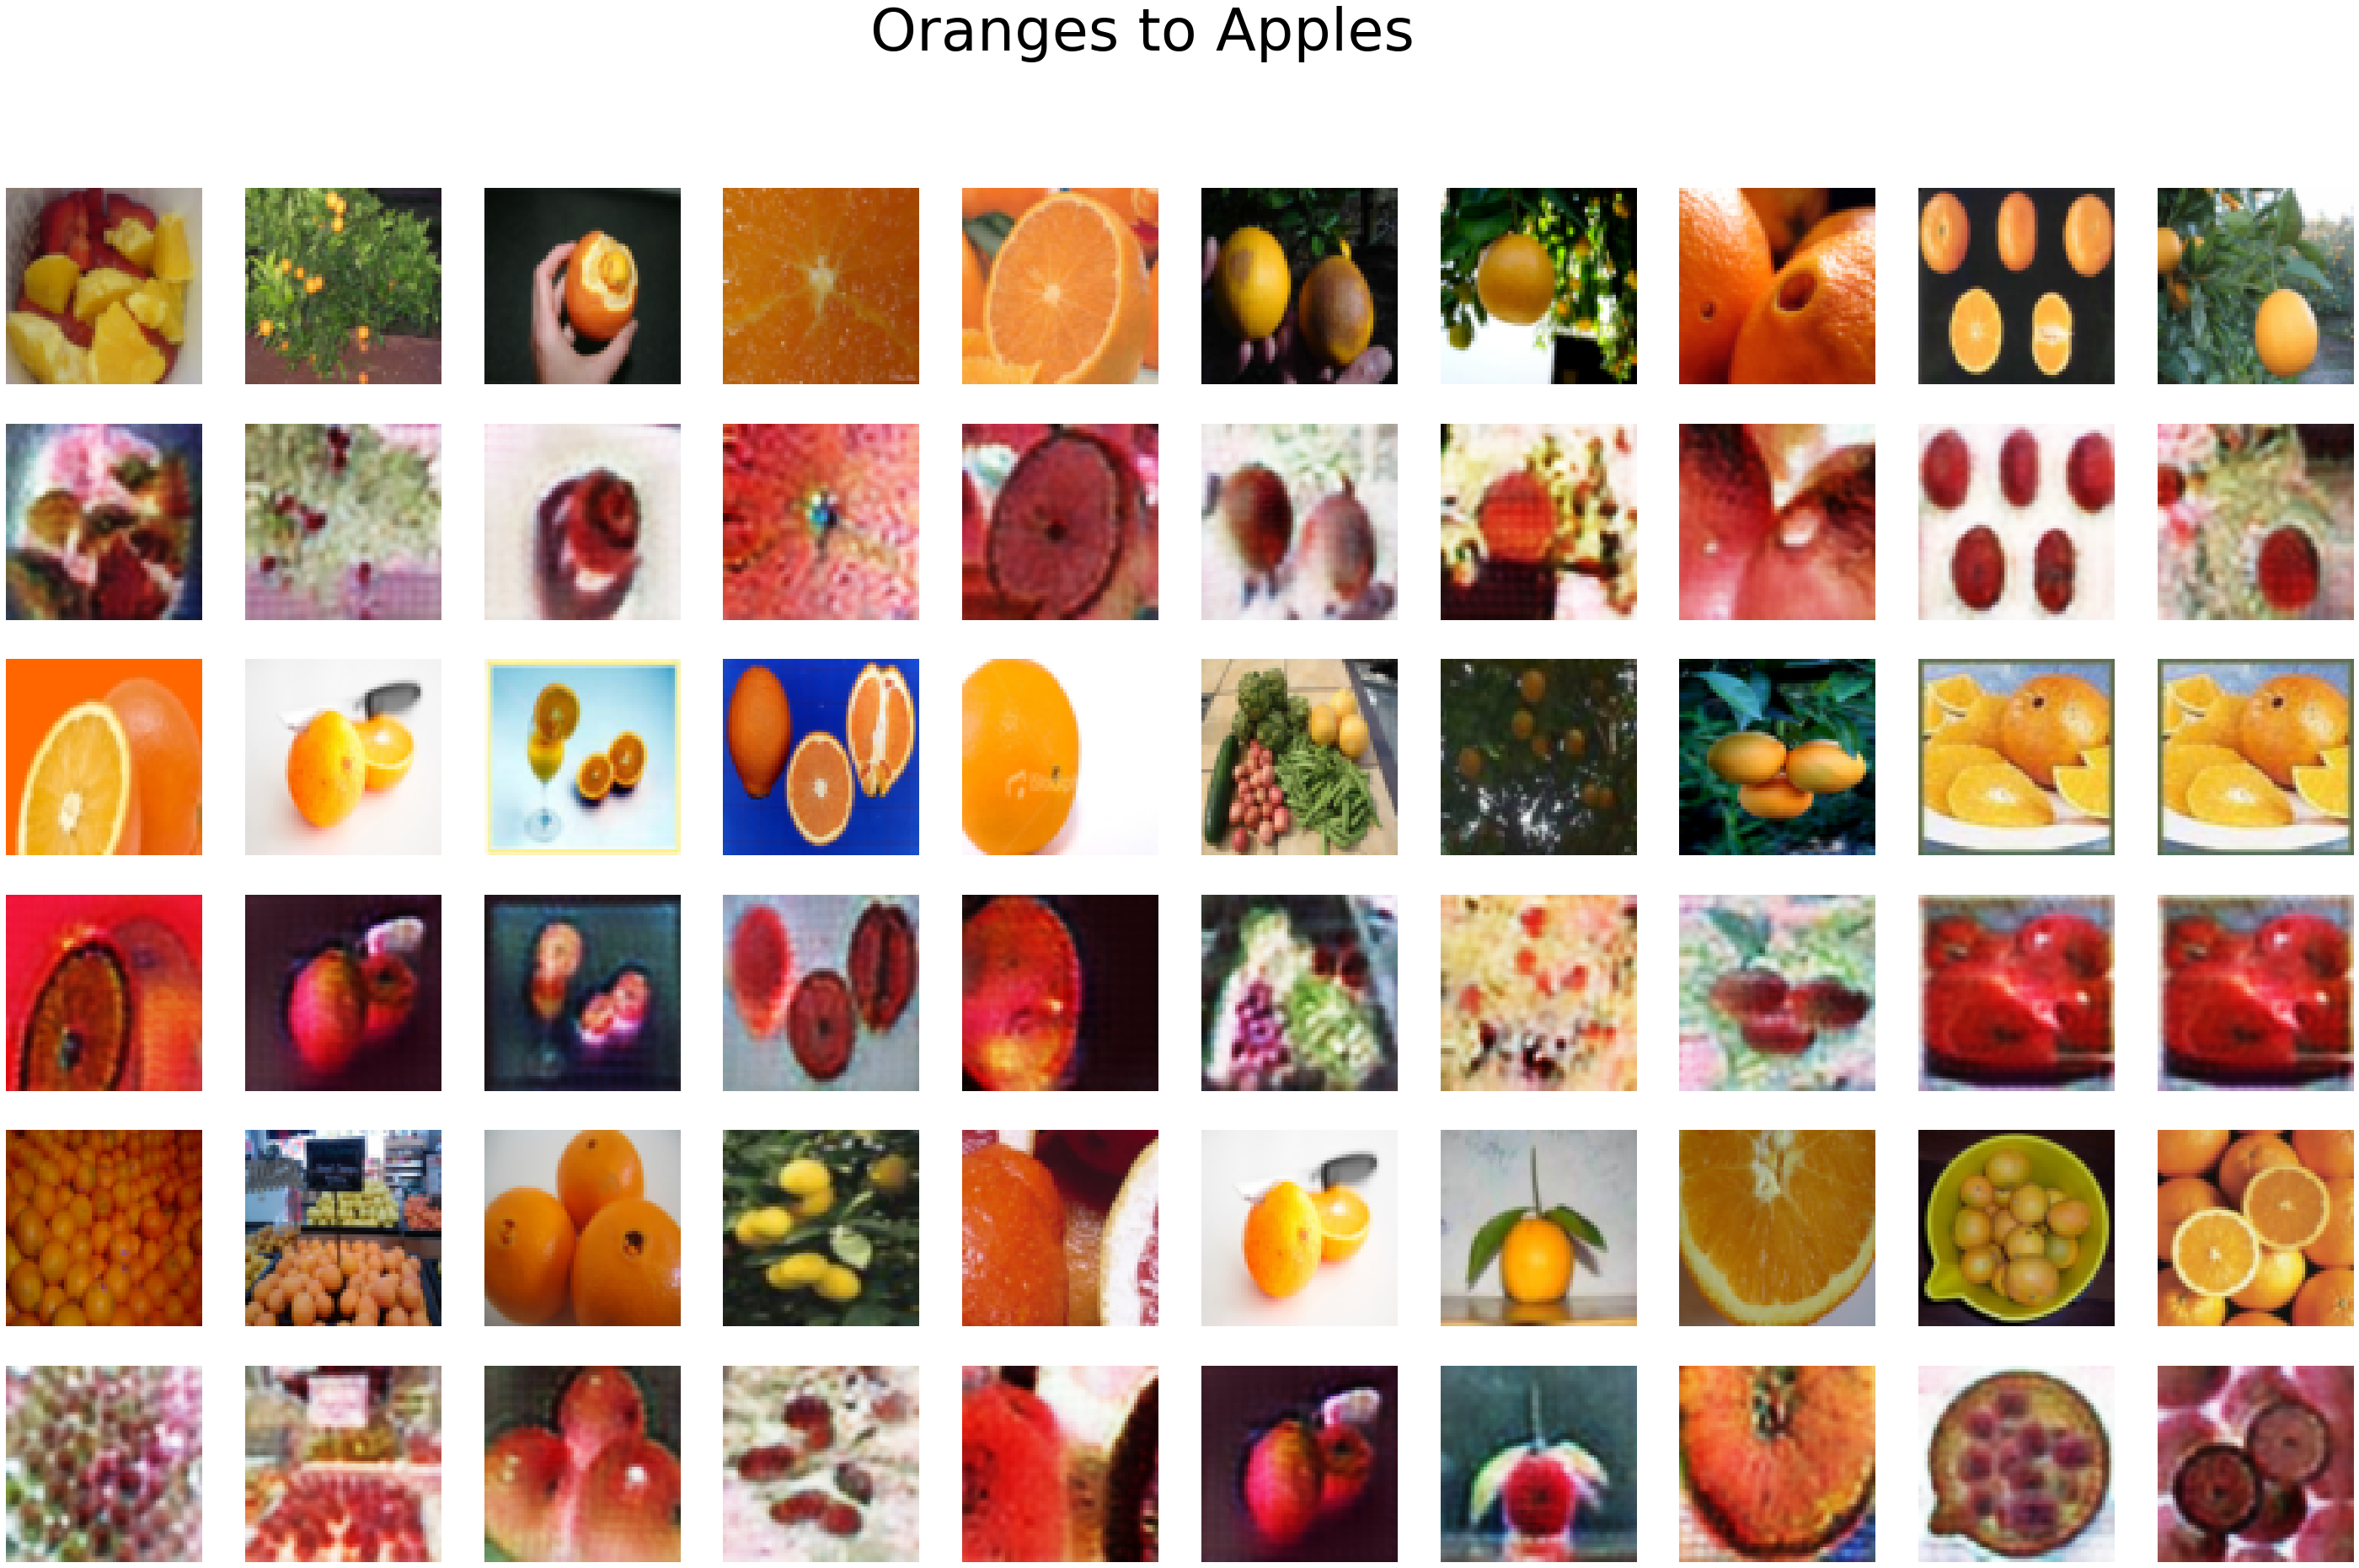

In [27]:
W = 10
H = 3
fig, axes = plt.subplots(2*H, W)
fig.suptitle('Apples to Oranges', fontsize=70)
for column in range(W):
    for row in range(H):
        x = datasetXtest[np.random.randint(len(datasetXtest))][0]
        axes[2*row, column].imshow((x.permute(1,2,0).numpy()+1)/2)
        axes[2*row, column].axis('off')
        y = Gy(x.unsqueeze(0).to(device)).detach().cpu()[0]
        axes[2*row+1, column].imshow((y.permute(1,2,0).numpy()+1)/2)
        axes[2*row+1, column].axis('off')
fig.set_figheight(10*H)
fig.set_figwidth(5*W)

fig, axes = plt.subplots(2*H, W)
fig.suptitle('Oranges to Apples', fontsize=70)
for column in range(W):
    for row in range(H):
        y = datasetYtest[np.random.randint(len(datasetYtest))][0]
        axes[2*row, column].imshow((y.permute(1,2,0).numpy()+1)/2)
        axes[2*row, column].axis('off')
        x = Gx(y.unsqueeze(0).to(device)).detach().cpu()[0]
        axes[2*row+1, column].imshow((x.permute(1,2,0).numpy()+1)/2)
        axes[2*row+1, column].axis('off')
fig.set_figheight(10*H)
fig.set_figwidth(5*W)

Unfortunately, with the limited training and model capacity, the results are dissapointing. It appears that the network has simply learned to change the color from red to orange and orange to red. However, there are signs of life with a few images showing the texture being subtly changed as well. Increasing the network capacity and training length should improve results.

Now let's examine how well the cycle consistency is respected. As before, the original image will be above its translation.

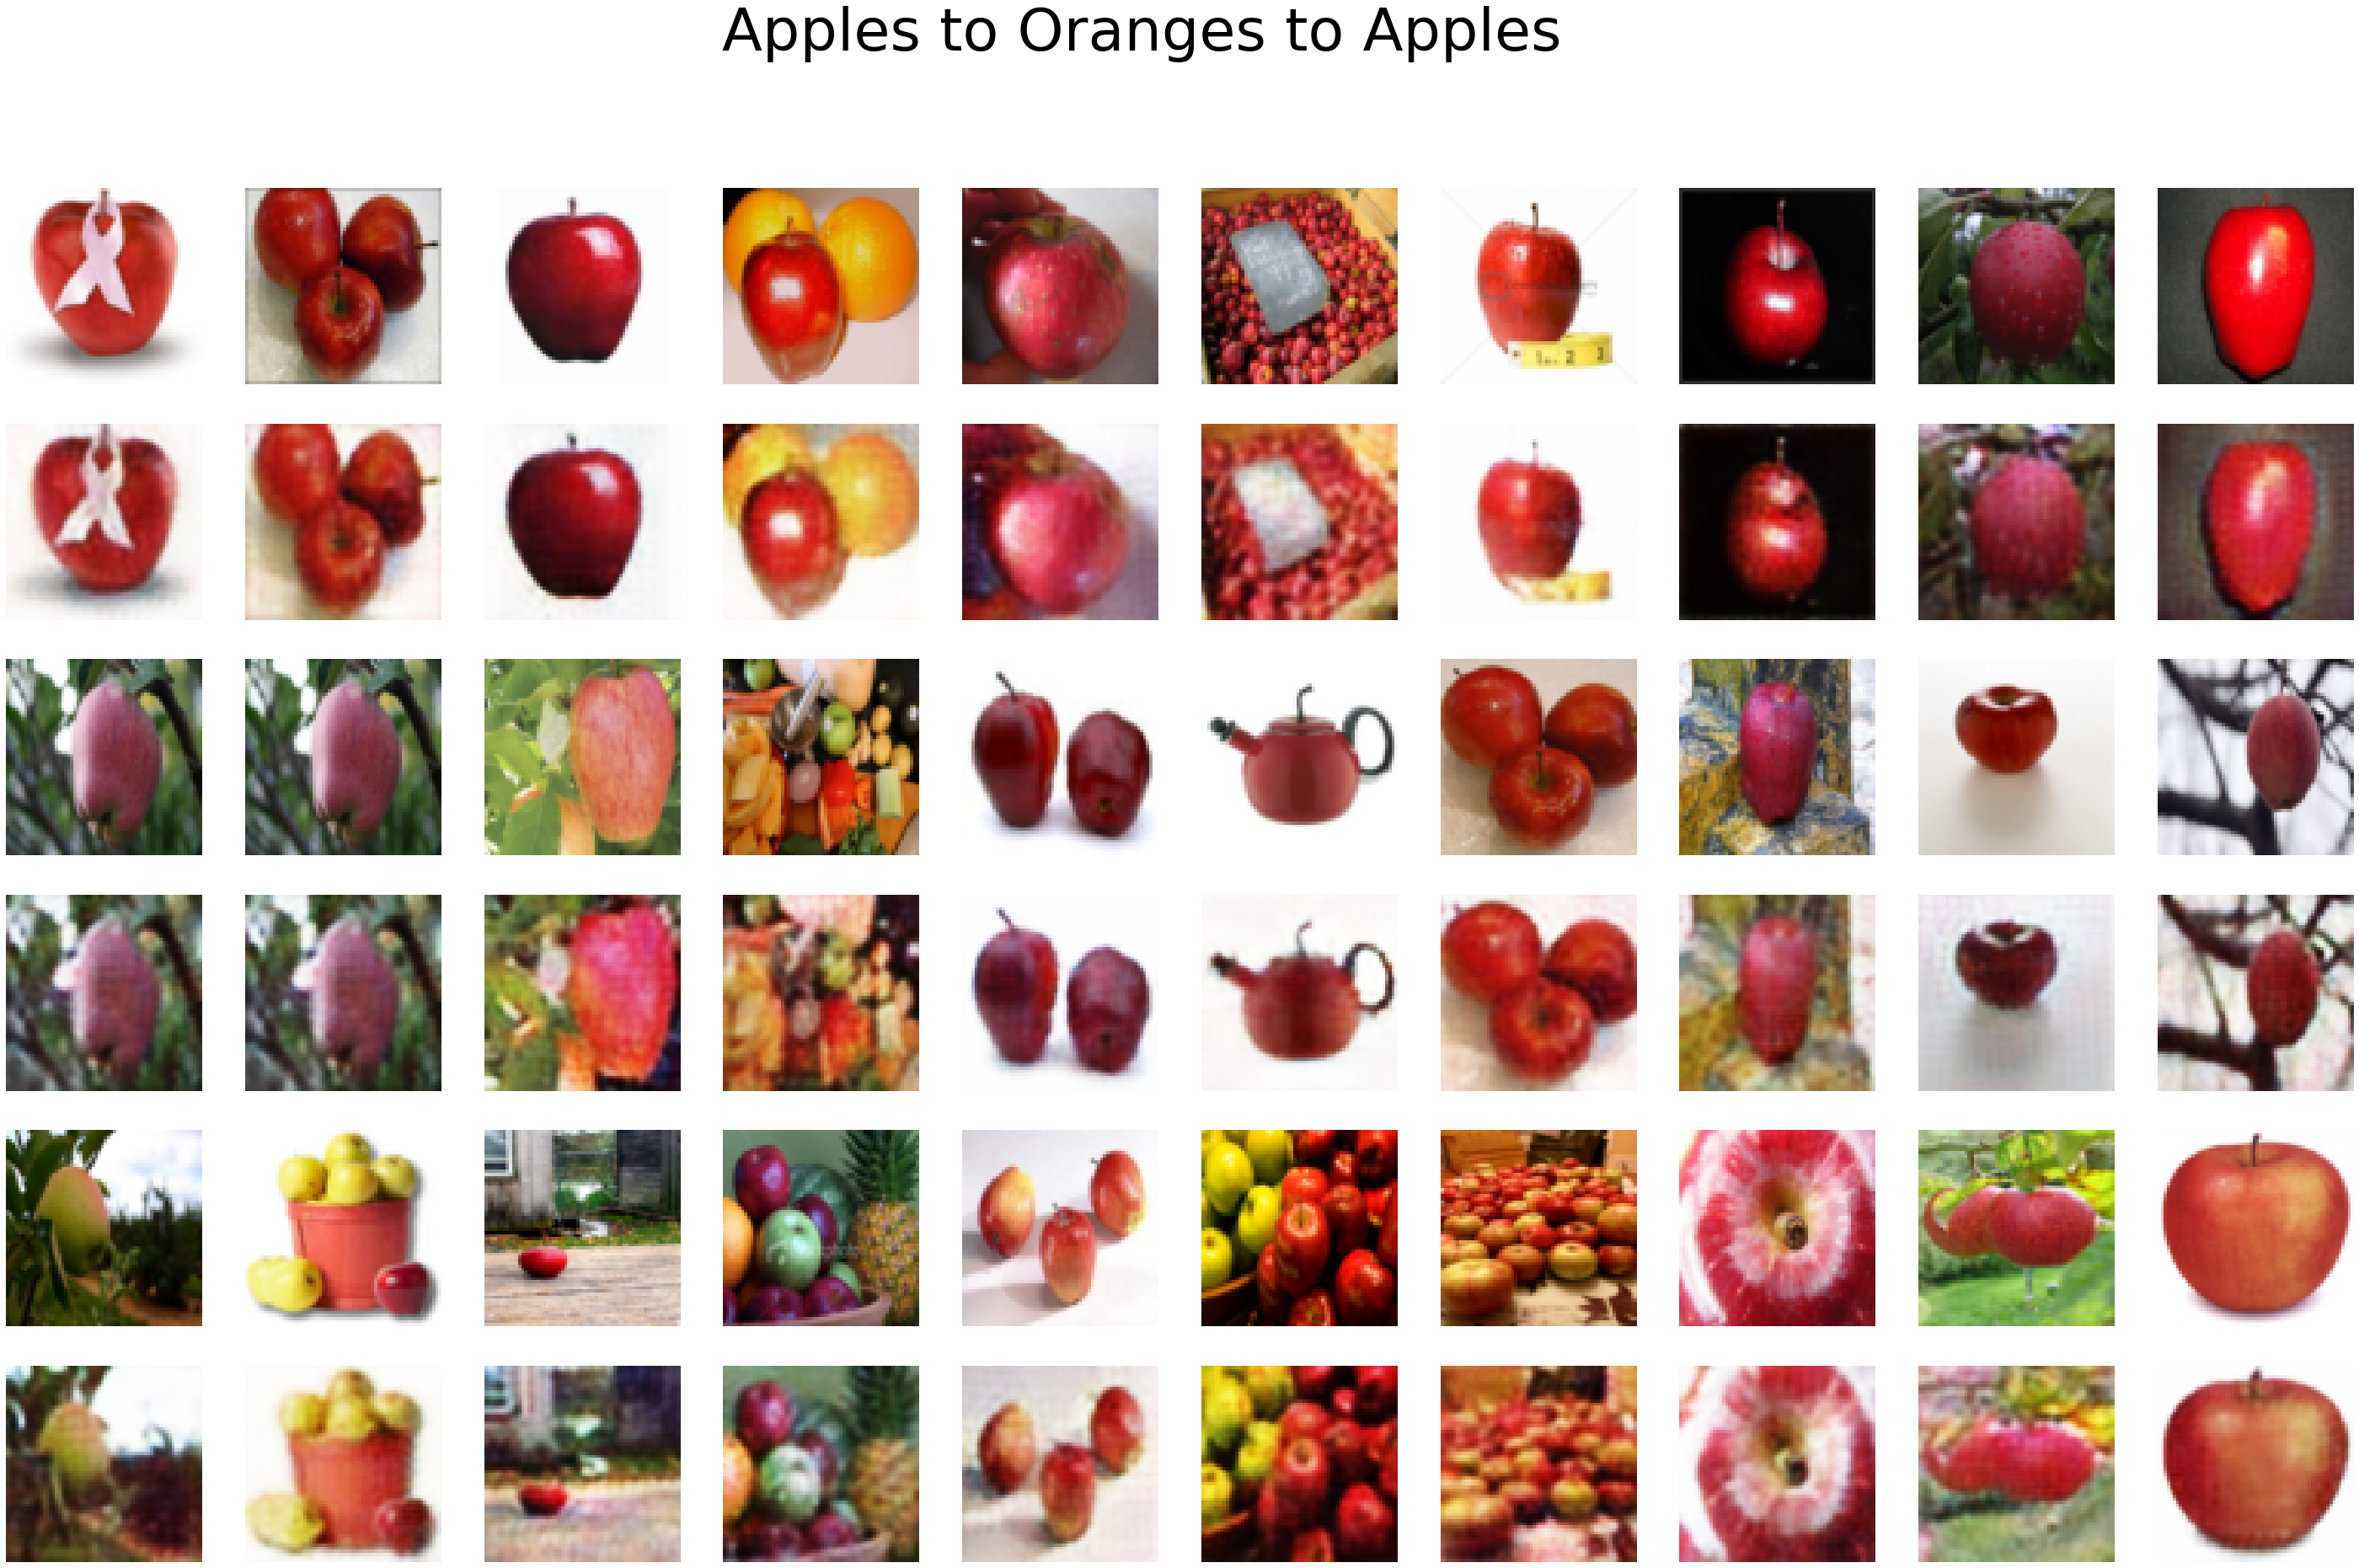

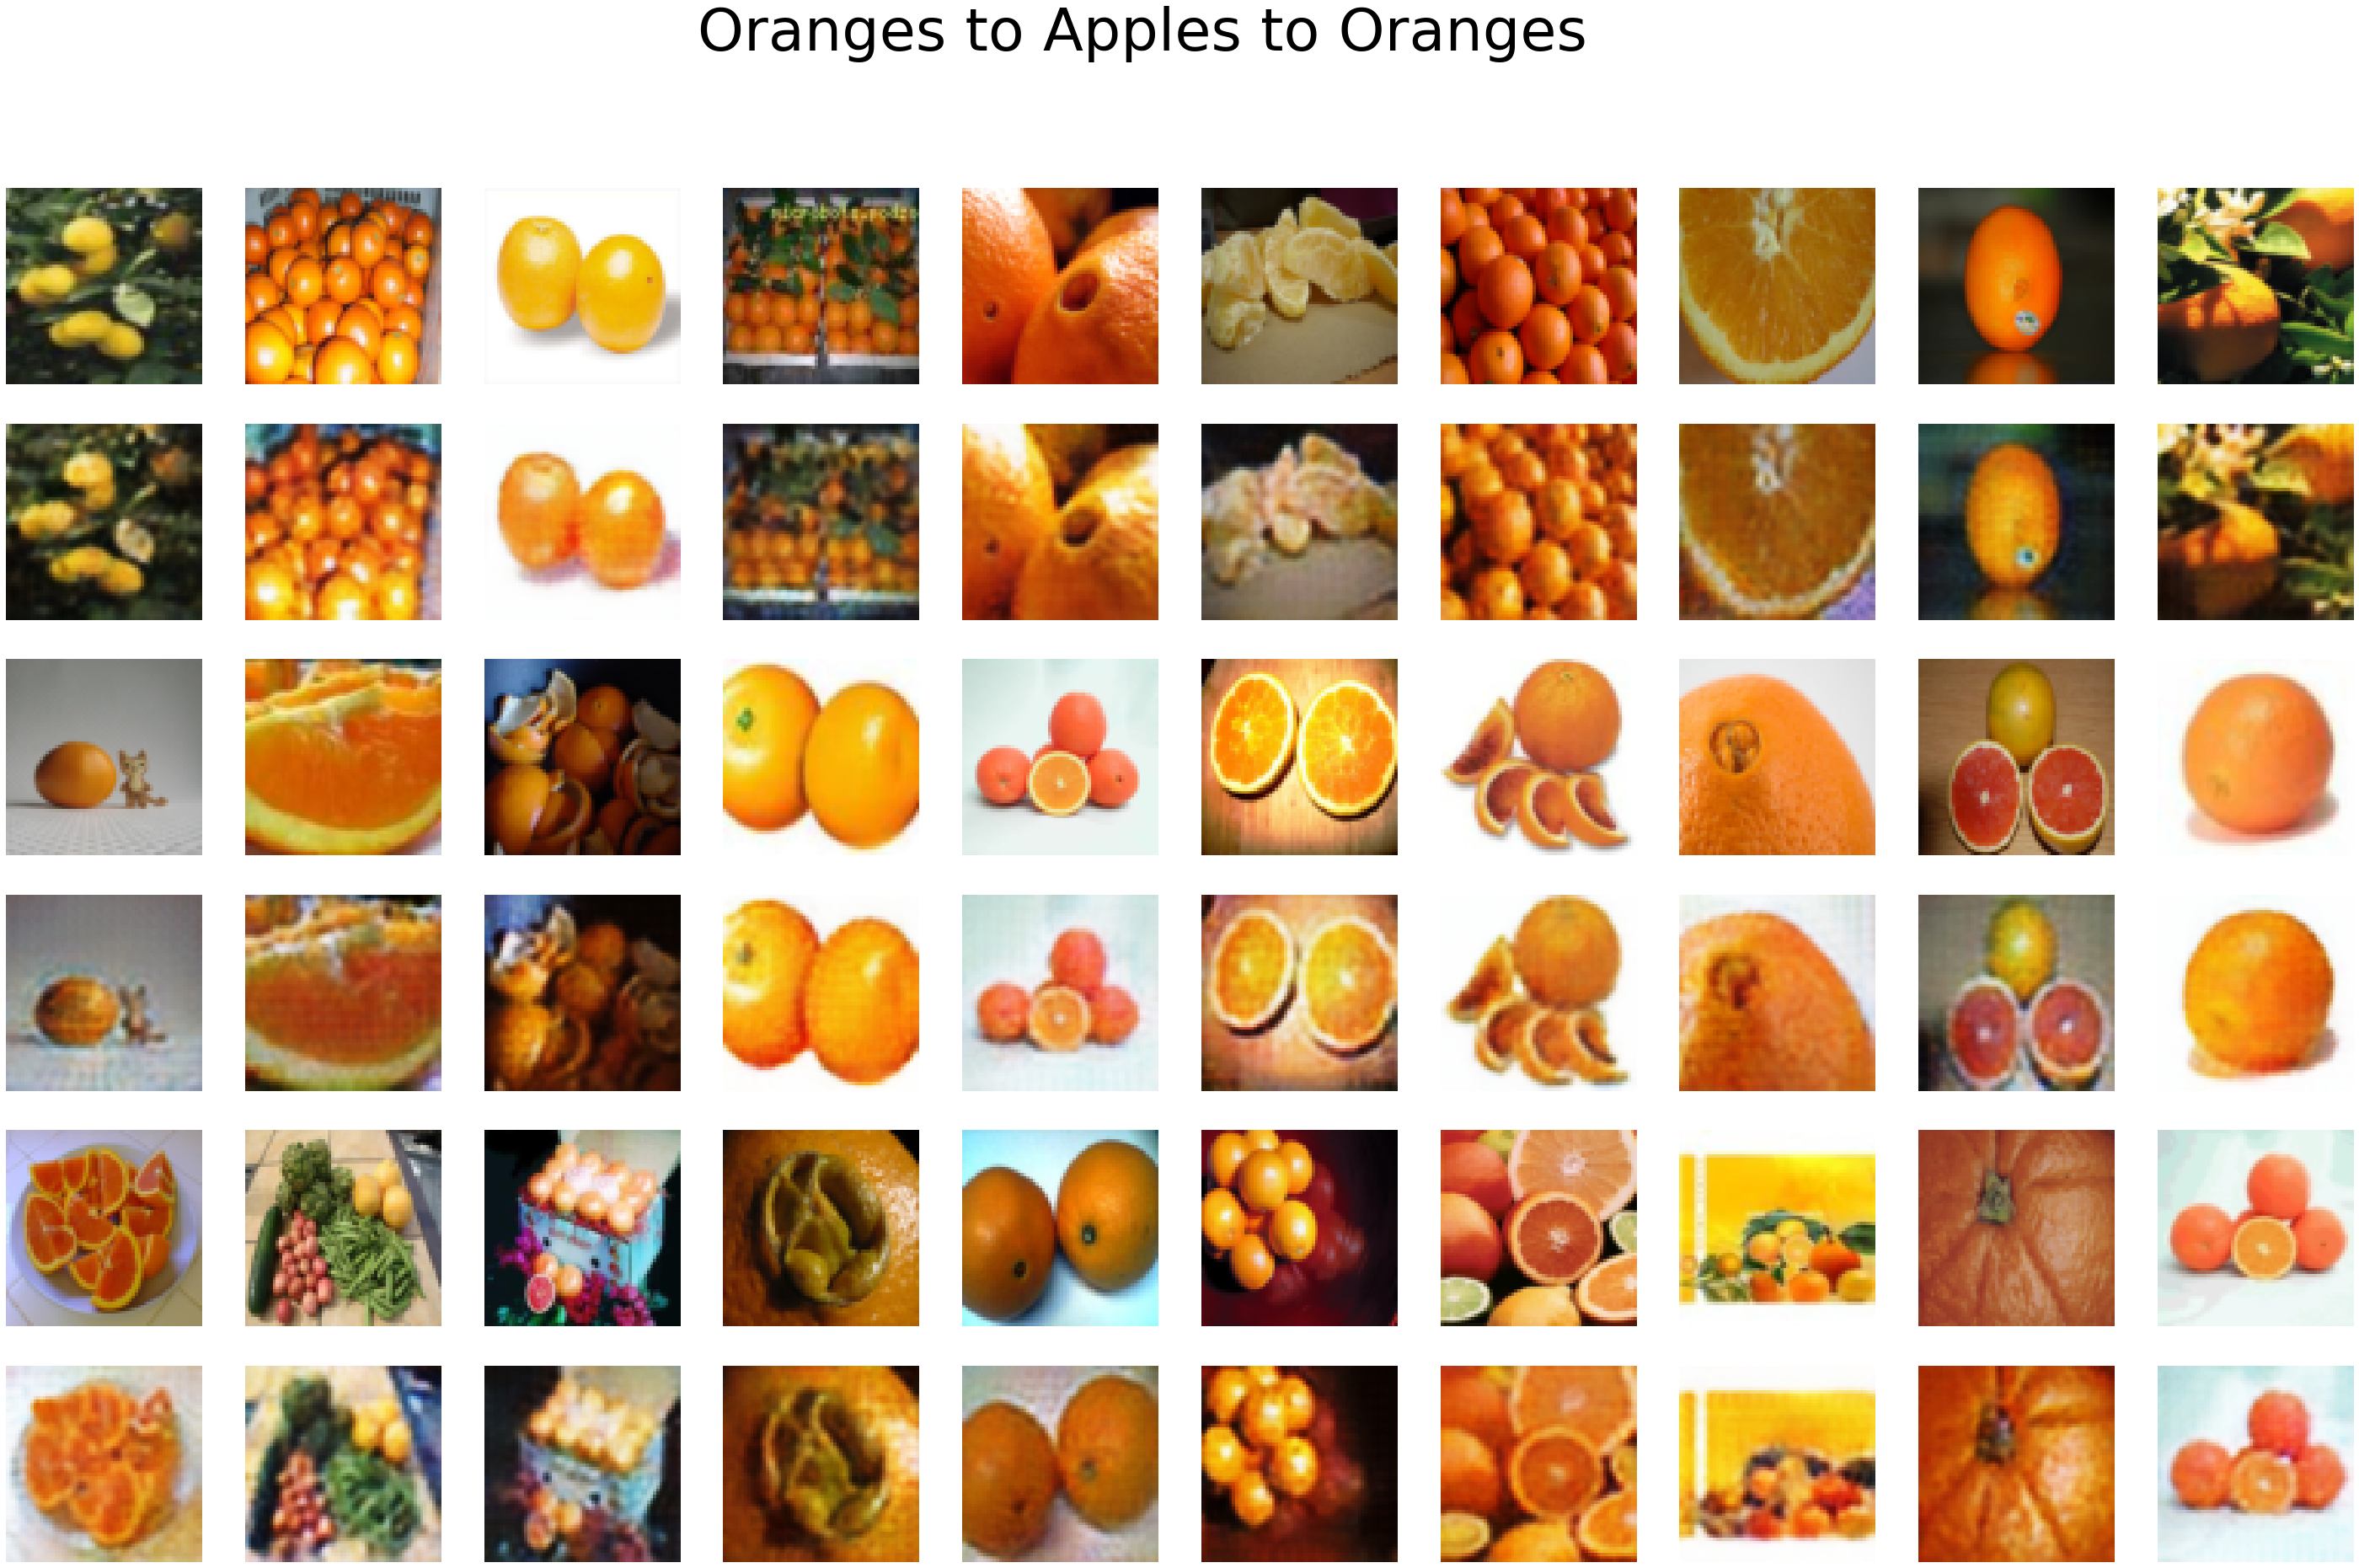

In [28]:
W = 10
H = 3
fig, axes = plt.subplots(2*H, W)
fig.suptitle('Apples to Oranges to Apples', fontsize=70)
for column in range(W):
    for row in range(H):
        x = datasetXtest[np.random.randint(len(datasetXtest))][0]
        axes[2*row, column].imshow((x.permute(1,2,0).numpy()+1)/2)
        axes[2*row, column].axis('off')
        y = Gx(Gy(x.unsqueeze(0).to(device))).detach().cpu()[0]
        axes[2*row+1, column].imshow((y.permute(1,2,0).numpy()+1)/2)
        axes[2*row+1, column].axis('off')
fig.set_figheight(10*H)
fig.set_figwidth(5*W)

fig, axes = plt.subplots(2*H, W)
fig.suptitle('Oranges to Apples to Oranges', fontsize=70)
for column in range(W):
    for row in range(H):
        y = datasetYtest[np.random.randint(len(datasetYtest))][0]
        axes[2*row, column].imshow((y.permute(1,2,0).numpy()+1)/2)
        axes[2*row, column].axis('off')
        x = Gy(Gx(y.unsqueeze(0).to(device))).detach().cpu()[0]
        axes[2*row+1, column].imshow((x.permute(1,2,0).numpy()+1)/2)
        axes[2*row+1, column].axis('off')
fig.set_figheight(10*H)
fig.set_figwidth(5*W)

The cycle consistency is very well respected, there is just a small decrease in image quality after completing a cycle. This suggests that $\lambda$, the parameter indicating the ratio of importance between the cycle loss and the GAN loss, may have been too high, i.e. the GAN loss was neglected in favor of the cycle consistency.

## Conclusion

First, we reviewed the idea behind CycleGANs. We then downloaded the apple2orange dataset from the original paper and implemented a CycleGAN. We trained it on the dataset and examined the resulting image translations.